In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_iris

iris_data = load_iris()
df = pd.DataFrame(np.c_[ iris_data['data'], iris_data['target'] ],
                    columns=iris_data['feature_names'] + ['target'])

In [3]:
def split_dataset(X, y, test_size, shuffle=True):
    n_samples = X.shape[0]
    permut = np.random.permutation(n_samples) if shuffle else range(n_samples)
    split_point = round((1-test_size)*n_samples)

    X_train, y_train = X[permut[:split_point]], y[permut[:split_point]]
    X_test, y_test = X[permut[split_point:]], y[permut[split_point:]]

    return X_train, X_test, y_train, y_test

In [4]:
def one_hot_encoder(target):
    keys = list(set(target))
    values = list(range(len(keys)))
    class_dict = {key:val for (key, val) in zip(keys, values)}

    target_one_hot = np.zeros((target.shape[0], len(keys)), dtype=int)
    for i, item in enumerate(target):
        target_one_hot[i, class_dict[item]] = 1

    return target_one_hot

In [5]:
X_iris = df.drop(columns=['target']).to_numpy()
y_iris = one_hot_encoder(df['target'].to_numpy())
X_train, X_test, y_train, y_test = split_dataset(X_iris, y_iris, test_size=0.2)

In [6]:
def relu(X):
    return np.maximum(X, 0.)

In [14]:
def relu_grad(X):
    X[X<=0] = 0.
    X[X>0] = 1.
    
    return X

In [7]:
def softmax(y_hat):
    y_hat = np.exp(y_hat)
    y_hat = y_hat / np.sum(y_hat, axis=0)

    return y_hat

In [75]:
class three_layer_nn:
    def __init__(self, X, y, n_hidden):
        self.X = X.T
        self.y = y.T
        self.n_samples, self.n_features = X.shape
        self.n_classes = y.shape[1]
        self.n_hidden = n_hidden

    def initial_weights(self):
        self.w_1 = np.random.random(size=(self.n_hidden, self.n_features))
        self.b_1 = np.zeros(shape=self.n_hidden)
        self.w_2 = np.random.random(size=(self.n_classes, self.n_hidden))
        self.b_2 = np.zeros(shape=self.n_classes)

    def compute_cost(self, y):
        loss = -np.sum(y*np.log(self.y_hat), axis=0)
        cost = np.sum(loss) / self.n_samples

        return cost

    def forward_propagation(self, X):
        self.z_1 = self.w_1 @ X + self.b_1.reshape(-1, 1)
        self.a_1 = relu(self.z_1)
        self.z_2 = self.w_2 @ self.a_1 + self.b_2.reshape(-1, 1)
        self.y_hat = softmax(self.z_2)

    def backpropagation(self, X, y):
        self.dz_2 = self.y_hat - y
        self.dw_2 = (self.dz_2 @ self.a_1.T) / self.n_samples
        self.db_2 = np.sum(self.dz_2, axis=1) / self.n_samples
        
        self.dz_1 = (self.w_2.T @ self.dz_2) * relu_grad(self.z_1)
        self.dw_1 = (self.dz_1 @ X.T) / self.n_samples
        self.db_1 = np.sum(self.dz_1, axis=1) / self.n_samples

    def update_params(self, learning_rate):
        self.w_1 = self.w_1 - learning_rate*self.dw_1
        self.b_1 = self.b_1 - learning_rate*self.db_1

        self.w_2 = self.w_2 - learning_rate*self.dw_2
        self.b_2 = self.b_2 - learning_rate*self.db_2

    def train_GD(self, learning_rate, epochs, random_state=1):
        np.random.seed(random_state)
        cost_history = np.zeros(shape=epochs)
        self.initial_weights()

        for epoch in range(epochs):
            self.forward_propagation(self.X)
            self.backpropagation(self.X, self.y)
            self.update_params(learning_rate)

            cost_history[epoch] = self.compute_cost(self.y)

            if (epoch+1) % (epochs//10) == 0 or epoch == 0:
                print(f'iteration: {epoch+1:>5}/{epochs},\tcost: {cost_history[epoch]:>6.5f}')

        return cost_history

In [76]:
model = three_layer_nn(X_train, y_train, 5)

In [80]:
epochs = 20000
lr = 0.01
h = model.train_GD(lr, epochs)

iteration:     1/20000,	cost: 2.80306
iteration:  2000/20000,	cost: 0.10721
iteration:  4000/20000,	cost: 0.07862
iteration:  6000/20000,	cost: 0.07027
iteration:  8000/20000,	cost: 0.06595
iteration: 10000/20000,	cost: 0.06329
iteration: 12000/20000,	cost: 0.06132
iteration: 14000/20000,	cost: 0.05972
iteration: 16000/20000,	cost: 0.05837
iteration: 18000/20000,	cost: 0.05718
iteration: 20000/20000,	cost: 0.05613


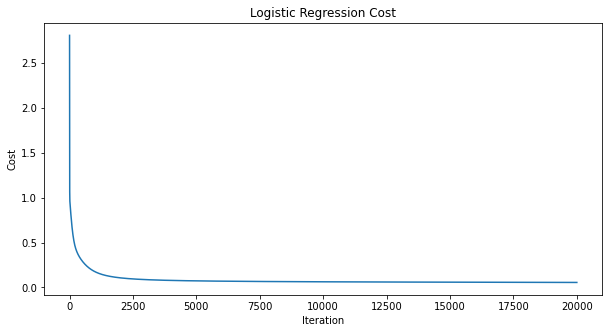

In [81]:
plt.figure(figsize=(10, 5))
plt.plot(list(range(epochs)), h)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title(f'Logistic Regression Cost')
plt.show()